In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
torch.__version__

'2.0.0'

In [5]:
torch.cuda.device_count()

1

In [6]:
mlxtend.__version__

'0.23.0'

1 - Cette premieres partie consiste en la préparation et à l'évaluation du modèle 

Importation et preparation des jeux de données.

In [8]:
train = pd.read_csv("/kaggle/input/traintest/Train.csv")
#dtrain = train.copy()
test = pd.read_csv("/kaggle/input/traintest/Test.csv")
#dtest = test.copy()

In [9]:
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [10]:
test.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


L'on se rend compte que nos ensembles de données contiennent à la fois les deux types d'images de riz en images RVB et Infrarouge. Procedons à une selection pour ne garder que les images RVB. 

In [11]:
train = train[~train['Image_id'].str.contains('_rgn')].reset_index(drop=True)
test = test[~test['Image_id'].str.contains('_rgn')].reset_index(drop=True)

Verifications

In [12]:
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy


In [13]:
test.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg
2,id_030ln10ewn.jpg
3,id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg


Tout est ok, passons à la repartition du jeu de données Train.csv en apprentissage/test

In [14]:
# Diviser l'ensemble de données en ensembles d'apprentissage et de test
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42)

train_df.head()

,Image_id,Label
2312,id_v1ha3bd3tc.jpg,healthy
69,id_0wb2ywiy2k.jpg,brown
1706,id_mzh77yjrsl.jpg,blast
1427,id_j3swinlswf.jpg,brown
881,id_br8cpj944r.jpg,blast


In [15]:
train_df.shape

(2136, 2)

In [16]:
test_df.head()

,Image_id,Label
1307,id_heszk4wzl8.jpg,blast
170,id_265q4z1ajs.jpg,brown
1809,id_ob0maoob4f.jpg,blast
1298,id_h7uxylua90.jpg,blast
1845,id_orl0slzk06.jpg,brown


In [17]:
test_df.shape

(534, 2)

In [18]:
test.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg
2,id_030ln10ewn.jpg
3,id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg


In [19]:
test.shape

(1145, 1)

Spécifions les transformations pour les données d'entraînement et de test

In [20]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Définition d'un ensemble de données personnalisé
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Colonne contenant les noms des fichiers
        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path).convert("RGB")  # Supposant des images RGB

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]  # Colonne contenant les étiquettes (classes)
        return image, label
        


# Créons des ensembles de données personnalisés
train_dataset = CustomDataset(dataframe=train_df, root_dir="/kaggle/input/images", transform=train_transform)
test_dataset = CustomDataset(dataframe=test_df, root_dir="/kaggle/input/images", transform=test_transform)


# Créons des chargeurs de données
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Choix et Evaluation du modèle pré-entrainé

In [21]:
# Charger un modèle pré-entraîné (ResNet50 dans notre cas)
model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 263MB/s]


In [22]:
# Recuperation des classes contenu dans la variable cible
class_dict = {class_name: idx for idx, class_name in enumerate(train['Label'].unique())}
print(class_dict)

{'blast': 0, 'brown': 1, 'healthy': 2}


Visualisation de la variable cible

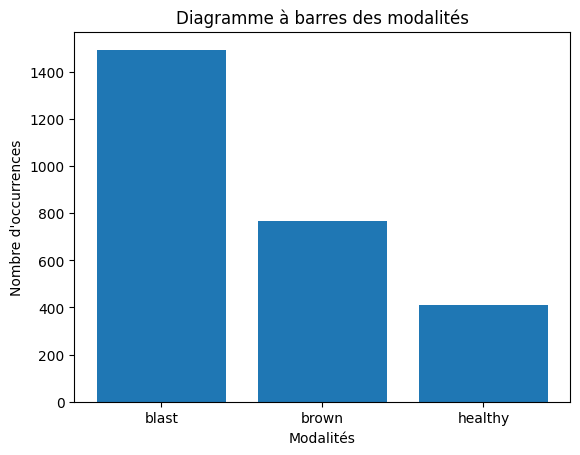

In [23]:
# Nombre d'occurrences de chaque modalité
modalities = train['Label'].value_counts()

# Diagramme à barres
plt.bar(modalities.index, modalities.values)

# Labels et un titre
plt.xlabel('Modalités')
plt.ylabel('Nombre d\'occurrences')
plt.title('Diagramme à barres des modalités')

# Affichage
plt.show()

Nous avons 3 classes alors nous pouvons ajusté le modèle pré-entrainé à notre tache spécifique

In [25]:
# Adapter les dernières couches à notre tâche
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,3) 

In [26]:
# Définition de la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10, Loss: 1.0300426249628636
Epoch 2/10, Loss: 0.6924649138948811
Epoch 3/10, Loss: 0.5955857808020577
Epoch 4/10, Loss: 0.6001819692440887
Epoch 5/10, Loss: 0.6491454096872415
Epoch 6/10, Loss: 0.508487362025389
Epoch 7/10, Loss: 0.4826276664858434
Epoch 8/10, Loss: 0.4693004233178808
Epoch 9/10, Loss: 0.4393189129099917
Epoch 10/10, Loss: 0.4217885781579943


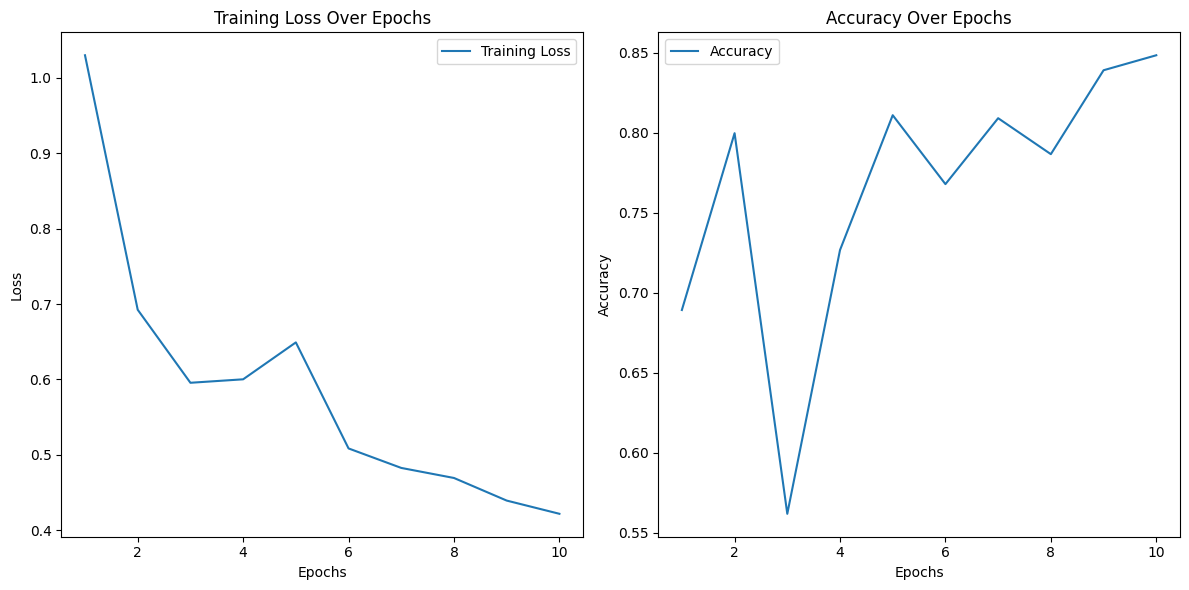

In [44]:
# Définition du répertoire qui contiendre les poids du modèle
#checkpoint_dir = "/kaggle/working/"
#os.makedirs(checkpoint_dir, exist_ok=True)

# Entraîner le modèle
#num_epochs = 10
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)


#train_losses = []  # Pour enregistrer les pertes d'entraînement

# Début du chronométrage
#from timeit import default_timer as timer 
#start_time = timer()

#for epoch in range(num_epochs):
    #model.train()
    #running_loss = 0.0
    
    #for inputs, labels_list in train_loader:
        #inputs = inputs.to(device)
        
        # Conversion des étiquettes en valeurs numériques à l'aide du dictionnaire class_dict
        #labels = [class_dict.get(label_str, -1) for label_str in labels_list]
        #labels = torch.tensor(labels).to(device)
        
        #optimizer.zero_grad()
        #outputs = model(inputs)
        #loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()
        
        #running_loss += loss.item()
    
    # Calcul de la perte moyenne sur l'ensemble d'entraînement
    #epoch_loss = running_loss / len(train_loader)
    #train_losses.append(epoch_loss)
    
    #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
    
    # Enregistrement des checkpoints à la fin de chaque époque
    #checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
    #torch.save({
        #'epoch': epoch,
        #'model_state_dict': model.state_dict(),
        #'optimizer_state_dict': optimizer.state_dict(),
        #'loss': epoch_loss,
    #}, checkpoint_path)

# Fin du chronométrage
#end_time = timer()
#print(f"[INFO] Délai total d'exécution: {end_time-start_time:.3f} secondes")
# Import necessary libraries
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


# Entraîner le modèle
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
accuracies = []

checkpoint_dir = "/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

best_accuracy = 0.0
best_checkpoint_path = ""

# Initialize the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

best_loss = float('inf')  # Initialize with positive infinity

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels_list in train_loader:
        inputs = inputs.to(device)
        labels = [class_dict.get(label_str, -1) for label_str in labels_list]
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

    # Validation sur l'ensemble de test pour calculer l'accuracy
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels_list in test_loader:
            inputs = inputs.to(device)
            labels = torch.tensor([class_dict.get(label_str, -1) for label_str in labels_list]).to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    
    # Adjust learning rate based on validation loss
    scheduler.step(epoch_loss)


    # Enregistrer le checkpoint à la fin de chaque époque
    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': accuracy,
    }, checkpoint_path)

        
    # Save the checkpoint based on the lowest validation loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_checkpoint_path = checkpoint_path

# Charger le meilleur checkpoint pour effectuer les prédictions
model.load_state_dict(torch.load(best_checkpoint_path)['model_state_dict'])
model.eval()

# Définir les transformations pour l'inférence
inference_transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
])

# Créer un DataFrame pour stocker les prédictions
predictions_df = pd.DataFrame(columns=['Image_id', 'blast', 'brown', 'healthy'])

# Prédire pour chaque image dans le fichier Test.csv
for index, row in test.iterrows():
    if "_rgn.jpg" in row['Image_id']:
        continue

    image_path = os.path.join('/kaggle/input/images', row['Image_id'])

    # Charger l'image et appliquer les transformations
    image = Image.open(image_path).convert('RGB')
    image = inference_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    # Effectuer la prédiction
    with torch.no_grad():
        model.eval()
        output = model(image)

    # Appliquer la fonction softmax pour obtenir les probabilités
    probs = torch.nn.functional.softmax(output, dim=1)

    # Récupérer les probabilités pour chaque classe
    prob_blast = probs[0, 0].item()
    prob_brown = probs[0, 1].item()
    prob_healthy = probs[0, 2].item()

    # Créer un dictionnaire avec les valeurs à ajouter
    new_row = {
        'Image_id': row['Image_id'],
        'blast': prob_blast,
        'brown': prob_brown,
        'healthy': prob_healthy
    }

    # Ajouter la nouvelle ligne au DataFrame
    predictions_df.loc[len(predictions_df)] = new_row

# Sauvegarder les prédictions dans un fichier CSV
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

# Tracer la courbe de la perte et de l'accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les deux graphiques
plt.tight_layout()
plt.show()

L'objet de ce script est de tenter de tenter d'obtenir automatiquement les poids .pth generant le fichier .csv des probabilités de predictions les plus optimales comparativement à ceux obtenues manuellement. 

Epoch 1/10, Training Loss: 0.4127373450727605
Epoch 1/10, Validation Loss: 0.31569595722591176
Epoch 2/10, Training Loss: 0.41598578942800635
Epoch 2/10, Validation Loss: 0.4217418046558605
Epoch 3/10, Training Loss: 0.3820682741812806
Epoch 3/10, Validation Loss: 0.48397938644184785
Epoch 4/10, Training Loss: 0.4004249065669615
Epoch 4/10, Validation Loss: 0.3504858499064165
Epoch 5/10, Training Loss: 0.3839121783402429
Epoch 5/10, Validation Loss: 0.3039550711126888
Epoch 6/10, Training Loss: 0.3887783889450244
Epoch 6/10, Validation Loss: 0.3220989169443355
Epoch 7/10, Training Loss: 0.3570365972483336
Epoch 7/10, Validation Loss: 0.30118631001781015
Epoch 8/10, Training Loss: 0.3425951752422461
Epoch 8/10, Validation Loss: 0.3606716035043492
Epoch 9/10, Training Loss: 0.36421898452203666
Epoch 9/10, Validation Loss: 0.38880585835260506
Epoch 10/10, Training Loss: 0.3566585328819147
Epoch 10/10, Validation Loss: 0.3749498952837551


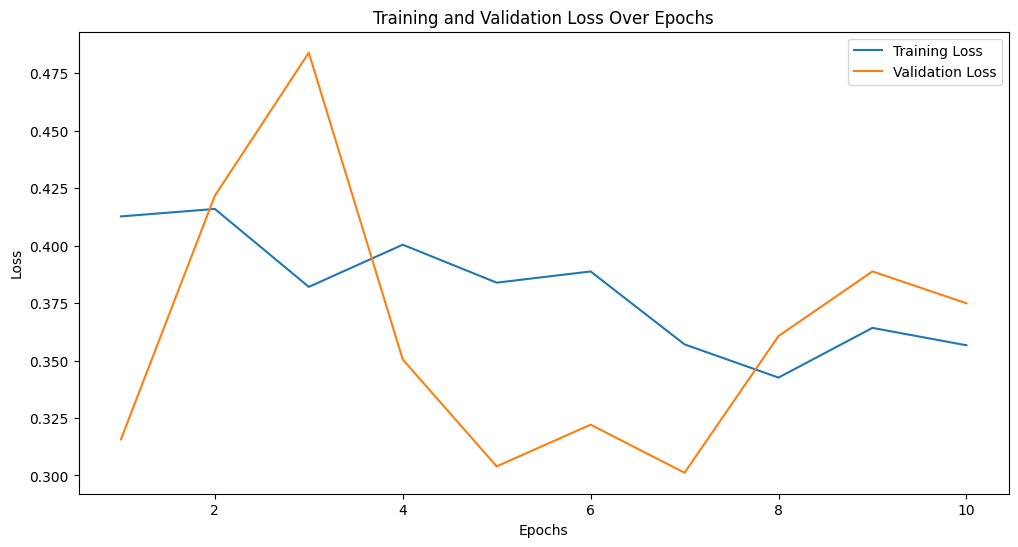

In [45]:
train_losses = []
eval_losses = []

checkpoint_dir = "/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

best_eval_loss = float('inf')
best_checkpoint_path = ""

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels_list in train_loader:
        inputs = inputs.to(device)
        labels = torch.tensor([class_dict.get(label_str, -1) for label_str in labels_list]).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss}')

    # Validation sur l'ensemble de test pour calculer la perte de journal
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, labels_list in test_loader:
            inputs = inputs.to(device)
            labels = torch.tensor([class_dict.get(label_str, -1) for label_str in labels_list]).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

    epoch_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(epoch_eval_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_eval_loss}')

    # Enregistrer le checkpoint à la fin de chaque époque
    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_train_loss,
        'eval_loss': epoch_eval_loss,
    }, checkpoint_path)

    # Mettre à jour le meilleur checkpoint si la perte de validation actuelle est meilleure
    if epoch_eval_loss < best_eval_loss:
        best_eval_loss = epoch_eval_loss
        best_checkpoint_path = checkpoint_path

# ... (le reste du code)

# Tracer la courbe de la perte d'entraînement et de validation
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

L'on constate une baisse regulière autant de la perte et de la precision au fil des époques. Toutefois la metrique d'evaluation pour cette competion etant la perte journalière et l'on constate que celle-ci est plus accrue autour des 8ieme et 9ieme époque ce sont donc celles contenant les poids optimaux pour le mondele.
Observons les performances du modèle à présent!

Évaluer le modèle sur l'ensemble de test

In [29]:
import torch.nn.functional as F

model.eval()
correct = 0
total = 0
test_loss = 0.0  # Pour enregistrer la perte sur l'ensemble de test

with torch.no_grad():
    for inputs, labels_list in test_loader:
        inputs = inputs.to(device)
        labels = torch.tensor([class_dict.get(label_str, -1) for label_str in labels_list]).to(device)
        
        outputs = model(inputs)
        
        # Calculer la perte
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculer la perte moyenne sur l'ensemble de test
average_test_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f'Accuracy on the test set: {accuracy}')
print(f'Average loss on the test set: {average_test_loss}')


Accuracy on the test set: 0.9438202247191011
Average loss on the test set: 0.16132044594954043


Le modèle presente plutôt de bonnes performances de généralisation avec une erreur moyenne de 16% et un accuracy de 94%. Nous verifirons ces resultats avec plus details dans la suite.

##### Recuperation des labels correctement predites du test dataset

In [30]:
test_correct = torch.cat([torch.tensor([class_dict.get(label_str, -1) for label_str in y]).to(device) for X, y in test_loader])
test_correct

tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2,
        0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0,
        2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 1,
        0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0,
        1, 2, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 2, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0,
        0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1,

In [31]:
from tqdm.auto import tqdm

# Effectuons des prédictions sur l'ensemble du jeu de données de test
test_preds = []
model.eval()

with torch.inference_mode():
    # Boucle à travers les lots dans le dataloader de test
    for X, labels_list in tqdm(test_loader):
        X = X.to(device)
        labels = torch.tensor([class_dict.get(label_str, -1) for label_str in labels_list]).to(device)

        # Transmissions des données au modèle
        test_logits = model(X)

        # Conversion les logits prédits en probes prédits
        pred_probs = torch.softmax(test_logits, dim=1)

        # Conversion les préd probs en pred labels
        pred_labels = torch.argmax(pred_probs, dim=1)

        # Ajout des labels pred à la liste des prédictions de test
        test_preds.append(pred_labels)

# Concaténons les prédictions de test et les placer sur l'unité centrale.
test_preds = torch.cat(test_preds).cpu()
test_preds


  0%|          | 0/17 [00:00<?, ?it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2,
        0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0,
        2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 1,
        0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0,
        1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 2, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1,

Cette étape nous permet de visualiser les classes correctement prédites afin de nous assurer que le modèle prédit toutes les classes contenues dans la variable label, ce que nous constatons fort bien. Appuyons nos observations au moyen d'un matrice de confusion 

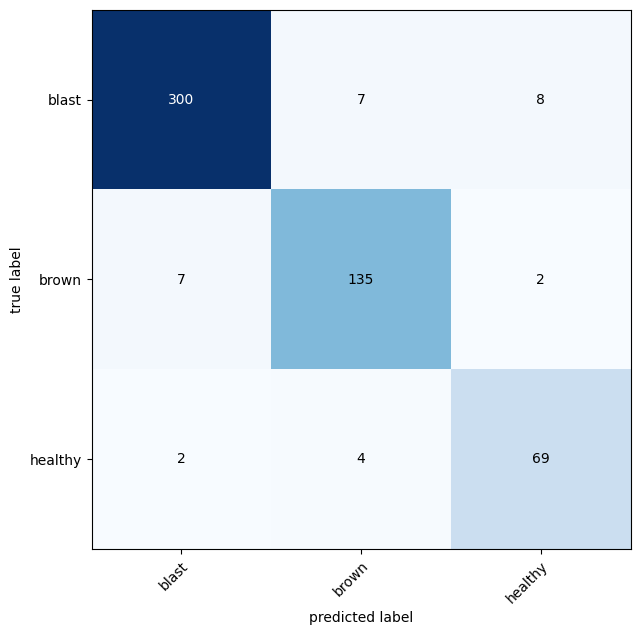

In [40]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Déplacement de test_preds et test_correct sur le même périphérique (CPU)
test_preds = test_preds.cpu()
test_correct = test_correct.cpu()

# Specifions la tache 'multiclass' dans notre cas
task = 'multiclass'

# Configuration de  l'instance de la matrice de confusion
confmat = ConfusionMatrix(num_classes=3, task=task).cpu()  # Déplacement l'instance de ConfusionMatrix vers le CPU
confmat_tensor = confmat(preds=test_preds, target=test_correct)

# Tracer de la matrice de confusion 
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib est mieux adapté aux objets NumPy
    class_names=list(class_dict.keys()),
    figsize=(10, 7)
)


L'on constate plutôt de meilleures performances de notre modèle sur les données de test